<a href="https://colab.research.google.com/github/juanosoriodata/atari/blob/master/Atari.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Hecho por *Juan Felipe Osorio Ramírez* en el curso de Minería de Datos en la Universidad Nacional de Colombia, Sede Bogotá.

El contenido se toma de las siguientes referencias:
1. Saito, S., Wenzhuo, Y., & Shanmugamani, R. (2018). Python Reinforcement Learning Projects: Eight hands-on projects exploring reinforcement learning algorithms using TensorFlow. Packt Publishing Ltd.

2. Evans, L. C. (1983). An introduction to mathematical optimal control theory version 0.2. Lecture notes available at http://math. berkeley. edu/~ evans/control. course. pdf.

***
# ATARI
***


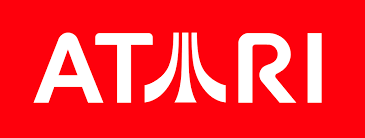

In [0]:
#@title
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAW0AAACKCAMAAABW6eueAAAAkFBMVEX+AAz////+AAD/8PH+AAX/0dH/9/j/srT/5uf+hYj+Fh3/8/T+d3n/3t7/w8P+bnD/ysz/mJr/2dr+X2P/4eL/+vr+eXz/6+z+rK7+kpX+JSr/x8n/v8H+gIP+Vlr/paf+nZ/+UFT+NTr+XWH+LjP+i47+RUn+Zmn+PkL+TVH/t7n+Cxb+REf+qKr+HSP+MjcC7DZvAAAK50lEQVR4nO2da2PaOgyGQQ2sLW1p6YAVGL2taws73f//dyc3J5YsO7YPcc4HvV/GRrCdJ44tS7I3GolEIpFIJBKJRCKRSCQSiUQikUgkEolEIpFIJBKJRCKRSCQSiUQiUbwyKJSmLlB1gfoECWsfXgBf+/n8fmO/Y4gSX9TzVa57GMG8+LB6AXhZ5R/mWVijM2fVnYX5NLUPZfA6WY4LTa5shOaTs2At5mxh8K2oapHTripdAVwUf06zINxwvLhds/WuJ9/uXr86gMN8qv1k9pgKN8B23Oj6F1ctPI2jxN5DRXuS056VF+VP+Gfx51l3f9Qbfbd01z1ZOXnDFbr6W6pR9OsM1fts1gvPcbDH40/mJhjaF6G04XjeXfn0yTFADEM7G52RRr4YFVd8YsTdBBx42jP/kQSOM7/636y8h6ENO9rC7ybt21ja2xDaI3/aE98GXH9ZMA5CG36bLbyiNcfTvuVo7+pvCO3p0Zd2Nc77acmMjGUZg9A+mA00OveJaW+rb7Ka9qqeJZeX3rQ9Bu1W77xlNADtDLiZnc5tJ6ZdDgPbnPa0vEbRHn950obPsEbsWctoANr8O7nrl/Z18c2NTntVfth43jE8BLbiL9eKIWhfs827xHWfmPb34pudTntefmBNfa7RoSbSmrEtB6ANL3zz3nqlXY66Oe2sov1T0f7oi/b4B7OGGID2D75154T2YX3OiPyG0frA0V4Xlx/y/tbQfi8/WKwHswBK+/bprtHT4bCjKwh2DTEA7amlM5CJhXf8oJua+vqlsuO0uj1F+wLgvvzAu1WYVhPa70atH3QRcfM/oE1q1MStSoiUAado+9pvsCmvf4Qae0H7tf7gWQKmzbw/AHvSj4w5YQDa9iXZZWft0bSrueJBp/1ZPwDPEjBt9iHBBq/tjbKT04ZfVtg5jK5fR9Pel9f/hOyysvXf8je//MDMZXwJHrTpIvl8eNqPen1rtM456492ZeLPG9oPUD92j+GrKsGHNrUA6FCSmnaGp7k7vIZ/7ao+mnb1jO8h+1K0s+OS7X+2EvxoH9FVdP2emnZt5SpdvqK/dna0aNrVU90D1LTvoLaNut+nugQv2mSV8DQ0bTRHXhOLrnOejKZdLV//AGyWikNdlOdi0pf2hQtnYtpkjsznKjSMF13OqWja1UPdqNG6pF0ueHyXN7600btr+H4S08axxmNWWwZK635o14ynWaZo58ZZ/ZqteqRNfQipaZ/RxhAX1b27AbG0KwNwliP+W/0yN/zqAJKnCehLG/k3h+3b9WpZqVg144GO9ShpiqVduUtz+0O5xPIbrflNTksbXUafZGLaW72yaeGTzEaoAR2TViztnXqUauQqaFej2vK0tNf6VW9D0iZkK18DfgKG0URKiKQ9axD/aequwwlsQgRThJ+9/Y6u+j0kbRL/qKwB0kC3/RtHWw0fxdT42dKuBnOjA1rK8KGd4a49owGFtLSRd1rZHyRK6XSBRtKup64raHKCDu2g4rd296GdkcwNOkkmpU2yn9SYQXwLzlkrkna9wPtsO3QOIrusHaSnog1kUDQjwUlp4yev5kOaXeKKy0bSbmvUaDczGp+NQMvoog2wJ+EbJiMpHW24REPGoqmqitA2cnmco2ireyxy/uoYQjl8KC+C8cKzhThpQ87a8Nuba4eUtN8s7SWT5/TktOuB5Bpai79cWP1TF+OTeemiDfDyaOb2MEuHlLRxF25vsQ5jNXLMkzG0Gy9osdZQFtBEX1j99LhrO22AdzYcxXjY0tEmyUa6JUCSGRzzZBTtO42Q8mMU41jjozEHWKYUG234wL1IieszCWkfrI0hTm8mNUApgnb7k6JYtaQpAGcjNZF4zJM22qpAKnaVlox2BqgitF4mDMf/nJJ2MyuUaw01epTGPizGLfuuYnjaxPPjhp2ONkn+wxWRWzHWYI3CaatgTW0EKfZT/S8+IzdPW6WnUFni2eloL1BF2PCnJreRzK0UQftGXVx2N+VgL9+tdnpeHrtunKfdmDVIS9vIlIo2Sf6jUQOSHL04GW3t/koXkVq4ViNZW22Hp9dCm+/ah8F3gpDGGuHRO/S1NRcylLYWmavM+GauLneAaE6DrlwWljbgIHapxafdfE9EOyPJf9TqyHBmgDWgEkgbtN1UPzDt8nnqVmmHXcLTNjYZfn937TlNRJvYSRMzUxKb3DYXfxht0BdUtX9X+WqqZbUeuWN3E7RlsbRpuu7Cvb83FW282lpfG0KOYWtsNog26DHP2m/ePNXK3kchf2dYwY921wuShLYtQd4uyzwZQhvBVrkTjWlU2XwqKFzJlezA0ybTTVccKBHtx3Go+HkygDa8oEvrLYzN0FHP0/ilc5jdPO1n0uoOfklo07Wij/iWeNPOiDdAeVWB/AOJ0/2wG2+sBWjcmDv5Pglt6gfx0ZLdEu1LG+iyo47HZl/qH5Tri1j6E1vM33d149zHk4a2955lTexb7UcbYE8mXbV4aU2+JipKvUqWXeq+K/fZ0BYg9V/76TqWdgbHG1qYmr20t6xx4pEHMz7/5IDZvFJ7WtXCEZtIQjvuoBFufu+mnZMyq2tiYVqYqAmLvhuX33yYvK0eV2OrLbelTV2cgnb4HGlrtZt2cQzRhvMTNWcqaIHoZj4j/rJS2096bpE9mmBsSLQnqCSgbXMBd2nJHGbhpA3w64Ihp3tlNLKNY4Q7USIfT54+RjoMR6TM2EZrTR1NQXtLW+MpJmfDRRveLRsxtfN1tJBGG6qzbfOd6jRccUkjAmw1bHqnDZfkHmZ24SuZLTFO2jY7s+1qelvaeI11OXDjRXuk9ju0sp2flIA2zl9Yuk54I5aiuZKOoa35E9HdtgMV5zgNoD0iKf9jayA7AW38nrlSZajta14bQftc62doMaJ5kCxb731pM/ubeZdx77SpQerapGccE2O8kBG0dVc6Mj+0nKyMs0sCaDNGLrs46582Tv5znwhH5yvDlgqnrdsHOO6vL5/gyM2w/rS18KcS51DsmzadI927XKhPzZgng2nj8RUnEOnJTObQG0Y7M464WQ6QK0WS/7oOX6HGFO0gobTxjkDi+L1yPIlQ2rltTg0b5vCd3mljfF37nOnpTXSeDKRNgs0kExGfH8IswkJoMxETMw2/Z9p0aOjafWo4sMg5hmG0SRydHh8xxYtV08EURJtxuBgJU33TJif/2Q6BbH9AFp4P/4E2NQvoqEZd//CbDAZhtJlj1WhsoW/auHZrVk77A9JB1tG0p3RDl3lWm7FVN8OGYCBt5lRJ0oZ+aZOtpz6J0uSYAWKf+9PeGU5TtXlPE910AjisG0rbDJtMkWerb9qkN3kcUUsDxtso2ud7xiAwF4xmMi1sNI9eOG0jNPEdtaNX2tSINQ8RY35DT0JCZqsf7fWKib602dqamGcC+2Y4CabNOKiQl75f2sapbj4/Iovou1Dalv8ZwMj9KMSlWee8d7G0mTPa9Xm+T9q0N029znGnoacZpo1W2EuD9uTtL3+WPs00rMVuFwQ4rnZLslsFz4DWg+3MyJnu/cJut5PSzt/Jia7uI9EKZYB+NFn8Qe/iVv/uFtH+uNrY/6MNeH67MPVmcZIVMbfjq/4uwgNqlD1vBJ4mRG0j4R4R8QPiq+4zKDkZ/8mJo8yMfBXQmM42ZfhL798ZVWQRhYhEIpFIJBKJRCKRSCQSiUQikUgkEolEIpFIJBKJRCKRSCQSiUQikUgkEp1U/wLnHZbL3qn/IwAAAABJRU5ErkJggg==")

Este cuaderno reproduce un proyecto de Aprendizaje Reforzado cuyo alcance es:
- Implementar un emulador del juego Atari usando `gym`.
- Explorar el preprocesamiento de datos en tareas de este tipo de aprendizaje, en este caso para el juego Atari.
- Explorar el algoritmo Q-learning.
- Implementar DQN usando TensorFlow y visualizar el entrenamiento.




### Intuición y Matemáticas detrás de escenas

### ¿Qué es el Aprendizaje Reforzado?

En este tipo de machine learning, se tiene un **agente** que se refiere al algoritmo/modelo que aprende una tarea específica.

El agente aprende principalmente al recibir una **señal de recompensa**, que es un escalar que indica que tan bien el agente está realizando la tarea.

Suponga que tenemos un agente cuya tarea es controlar el movimiento de caminar de un robot. El agente recibirá una recompensa positiva si logra hacer caminar el robot al destino fijado y recompensa negativa si se cae o no camina en dirección del destino.

Además, estas señales de recompensa se retornan como consecuencia de una serie de **acciones** que el agente realiza; esto a diferencia de como se retribuye la señal en un modelo de aprendizaje supervisado, en el cual se hace inmediatamente se entrena el modelo. Las acciones son simplemente esas opciones disponibles que tiene el agente para hacer en el **ambiente**. El ambiente se refiere al mundo en el que el agente vive y se encarga principalmente de retornar las señales de recompensa al agente. Las acciones del agente normalmente están condicionadas a lo que el agente percibe del ambiente. Lo que el agente percibe se concibe como la **observación** o el **estado** del ambiente. 

Nota: Lo que distingue el aprendizaje reforzado de otros paradigmas es que las acciones que realiza el agente pueden alterar el ambiente y sus respuestas subsecuentes.

### Ejemplo: Space Invaders de Atari

En este caso el agente tiene como tarea jugar **Space Invaders**, el juego de Arcade Atari 2600. El ambiente es el juego como tal y la lógica que este tiene en sus especificaciones. Durante el juego, el agente consulta al ambiente para hacer una observación (que es equivalente a tener un estado). Aquí la observación es un array de tamaño $(210,160,3)$, que coincide  con la pantalla del juego que muestra la nave del agente, los enemigos, el punntaje y cualquier proyectil. Basado en esta observación, el agente realiza algunas acciones, que pueden incluir el moverse a la izquierda o derecha, disparar un laser o quedarse quieto. El ambiente recibe la acción del agente como *input* y hace los respectivos *updates* al estado.

Por ejemplo, si el laser toca una nave enemiga, se remueve del juego. Si el agente decide moverse a la izquierda, el juego hará el update de cambiar las coordenadas de acuerdo a esto. Este proceso se repite hasta que se alcanza **estado terminal**, un estado que representa el final de una sucesión. En Space Invaders, el estado terminal se alcanza cuando la nave del agente es destruida, y el juego subsecuentemente retorna el puntaje que lleva, que se calcula con base en el número de naves enemigas que se destruyeron.

Nota: Algunos ambientes no tienen estados terminales, como el mercado de acciones. Estos siguen andando mientras existan.

### Resumen de términos  

Término | Descripción | Ejemplos
--- | --- | ---
Agente | Un algoritmo/modelo que aprende una tarea específica. | Carros Self-Driving, Robots que caminan, **jugador de video juegos**. 
Ambiente | El mundo en el que el agente actúa. Es responsable de controlar los que el agente percibe y provee la retroalimentación sobre que tan bien el agente realiza la tarea. | El camino sobre el que anda el carro, **un video juego**, el mercado de las acciones.
Acción | La decisión que toma el agente en un ambiente, usualmente depende de lo que el agente percibe | Dirigir un carro, comprar o vender una acción, **disparar un laser de la nave que el agente controla**.
Señal de recompensa| Un escalar que indica que tan bien el agente está realizando una tarea.| **El puntaje de Space Invaders**, ROI de una compra de acción, distancia recorrida por un robot que intenta caminar.
Observación/Estado| Una descripción de el ambiente tal como la percibe el agente | Video desde una cámara, **la pantalla del juego**, estadísticas del mercado de acciones.
Estado terminal|Un estado en el que el agente no puede realizar más acciones.| Llegar al final de un laberinto, **la nave del agente en Space Invaders es destruida**.

## Infrastructura y Dependecias 

## Aprendizaje de Máquina en Acción

## 